# ThreeStepTurning
---

## Cargar datasets

In [178]:
import os
import pandas as pd
import numpy as np

import copy

In [179]:
data_path = 'data/'
drivers = list(os.listdir(data_path))
print("Drivers: " ,drivers)

maneuver_types = [f.split("_")[1].split(".")[0] for f in os.listdir(os.path.join(data_path, drivers[0]))]
print("Maneuvers set: ", maneuver_types)

Drivers:  ['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5']
Maneuvers set:  ['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings']


In [180]:
# Get all drivers data
dfs = {}
for driver in drivers:
    maneuvers = {}
    for maneuver in maneuver_types:
        df_path = os.path.join(data_path, driver, f"STISIMData_{maneuver}.xlsx")
        df = pd.read_excel(df_path)
        maneuvers[maneuver] = df
    dfs[driver] = maneuvers

print(dfs.keys())
print(dfs[drivers[0]].keys())

dict_keys(['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5'])
dict_keys(['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])


In [181]:
def get_dfs_copy(dfs):
    return copy.deepcopy(dfs)

dfs_copy = copy.deepcopy(dfs)

## Selección de atributos

Se selecciona el conjunto de atributos mencionados en el enunciado.  
Este conjunto contiene **7** atributos: `speed`, `RPM`, `Steering wheel angle`, `Gas pedal`, `Brake pedal`, `Clutch pedal`, `Gear`.  
La etiqueta o clase se corresponde con el atributo `Maneuver marker flag`.

In [182]:
# Allowed attributes
attributes = ['speed', 'RPM', 'Steering wheel angle', 'Gas pedal', 'Brake pedal', 'Clutch pedal', 'Gear', 'Maneuver marker flag']
features = ['speed', 'RPM', 'Steering wheel angle', 'Gas pedal', 'Brake pedal', 'Clutch pedal', 'Gear']
target = 'Maneuver marker flag'

# Drop unnecessary columns
for driver in drivers:
    for maneuver in maneuver_types:
        dfs_copy[driver][maneuver] = dfs_copy[driver][maneuver][attributes]

dfs_copy[drivers[0]][maneuver_types[0]].head()

,speed,RPM,Steering wheel angle,Gas pedal,Brake pedal,Clutch pedal,Gear,Maneuver marker flag
0,0.06,147.244,-8.24,0,0,0,0,0
1,0.04,184.118,-8.24,0,0,0,0,0
2,0.02,219.193,-8.24,0,0,0,0,0
3,0.00,252.554,-8.24,0,0,0,0,0
4,0.00,284.287,-8.24,0,0,0,0,0


## EDA (Análisis Exploratorio de Datos)

In [183]:
dfs_copy[drivers[0]][maneuver_types[0]]

,speed,RPM,Steering wheel angle,Gas pedal,Brake pedal,Clutch pedal,Gear,Maneuver marker flag
0,0.06,147.244,-8.24,0,0,0,0,0
1,0.04,184.118,-8.24,0,0,0,0,0
2,0.02,219.193,-8.24,0,0,0,0,0
3,0.00,252.554,-8.24,0,0,0,0,0
4,0.00,284.287,-8.24,0,0,0,0,0
...,...,...,...,...,...,...,...,...
8928,72.21,2569.974,-1.02,44336,0,8545,3,0
8929,72.36,2575.470,0.00,44336,0,8545,3,0
8930,72.52,2580.899,3.08,44336,0,8545,3,0
8931,72.67,2586.331,5.14,44336,0,8545,3,0


In [184]:
dfs_copy[drivers[0]][maneuver_types[0]].dtypes

speed                   float64
RPM                     float64
Steering wheel angle    float64
Gas pedal                 int64
Brake pedal               int64
Clutch pedal              int64
Gear                      int64
Maneuver marker flag      int64
dtype: object

In [185]:
dfs_copy[drivers[0]][maneuver_types[0]].describe()

,speed,RPM,Steering wheel angle,Gas pedal,Brake pedal,Clutch pedal,Gear,Maneuver marker flag
count,8933.000000,8933.000000,8933.000000,8933.000000,8933.000000,8933.000000,8933.000000,8933.000000
mean,27.076534,1690.436524,-4.288223,19731.515392,1187.196239,32681.562745,0.983656,0.591627
std,27.264831,960.969137,229.965259,17383.355246,3626.100086,23721.195196,1.346223,0.491560
min,0.000000,124.919000,-466.580000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,3.220000,921.292000,-56.640000,0.000000,0.000000,11565.000000,0.000000,0.000000
50%,14.510000,1282.623000,-2.060000,20160.000000,0.000000,25828.000000,1.000000,1.000000
75%,49.460000,2358.363000,14.420000,35405.000000,0.000000,64253.000000,2.000000,1.000000
max,84.590000,4774.648000,414.060000,59627.000000,29041.000000,64253.000000,4.000000,1.000000


## Preprocesamiento de los datos

In [186]:
maneuver_ind = 0
print(maneuver_types[maneuver_ind])

3step-Turnings


En este apartado se llevan a cabo las siguientes modificaciones para generar el dataset final:   
- Se añaden 8 nuevos atributos con datos de instancias previas utilizando ventanas deslizantes.   
    - `speed_mean` y `speed_std`: Media y desviación estándar de la velocidad en las últimas *window_size* instancias.
    - `RPM_mean` y `RPM_std`: Media y desviación estándar de las RPM en las últimas *window_size* instancias.
    - `brake_mean` y `brake_std`: Media y desviación estándar del freno en las últimas *window_size* instancias.
    - `gas_mean` y `gas_std`: Media y desviación estándar del acelerador en las últimas *window_size* instancias.
- Se establece como etiqueta el atributo `Maneuver marker flag` de la **siguiente instancia** puesto que el objetivo será predecir si la maniobra va a suceder o no.
- Se dividen los datos de los conductores en conjuntos de *train* y *test* con la siguiente distribución:
    - *Train*: 80% de los datos de cada conductor.
    - *Test*: 20% de los datos de cada conductor.   

El motivo de esta división es homogeneizar ambos conjuntos para evitar sesgos de los conductores en la evaluación del modelo.   
Cabe destacar que en esta división se mantiene la secuencialidad de los datos al tratarse de series temporales.

### Con Overlapping

In [187]:
window_size = 60  
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# Iterar sobre todos los conductores para una misma maniobra
for driver in drivers:
    df = copy.deepcopy(dfs_copy[driver][maneuver_types[maneuver_ind]])  # Selecciona la maniobra

    # Agregar ID del conductor (opcional, por trazabilidad)
    df['driver_id'] = driver  

    # Crear nuevas características con ventana deslizante
    df['speed_mean'] = df['speed'].rolling(window=window_size, min_periods=1).mean()
    df['speed_std'] = df['speed'].rolling(window=window_size, min_periods=1).std()
    df['RPM_mean'] = df['RPM'].rolling(window=window_size, min_periods=1).mean()
    df['RPM_std'] = df['RPM'].rolling(window=window_size, min_periods=1).std()
    df['brake_mean'] = df['Brake pedal'].rolling(window=window_size, min_periods=1).mean()
    df['brake_std'] = df['Brake pedal'].rolling(window=window_size, min_periods=1).std()
    df['gas_mean'] = df['Gas pedal'].rolling(window=window_size, min_periods=1).mean()
    df['gas_std'] = df['Gas pedal'].rolling(window=window_size, min_periods=1).std()

    # Definir el target: si ocurre una maniobra en el próximo instante (t+1)
    df['target'] = df['Maneuver marker flag'].shift(-1)

    # Eliminar filas con valores NaN creados por shift y rolling
    df = df.dropna()

    # Seleccionar variables relevantes
    X_driver = df.drop(columns=['Maneuver marker flag', 'target', 'driver_id'])  # Excluir driver_id si no se usa
    y_driver = df['target']

    # Split temporal **para cada conductor**
    split_index = int(len(X_driver) * 0.8)  

    X_train_driver, X_test_driver = X_driver.iloc[:split_index], X_driver.iloc[split_index:]
    y_train_driver, y_test_driver = y_driver.iloc[:split_index], y_driver.iloc[split_index:]

    # Agregar a las listas
    X_train_list.append(X_train_driver)
    X_test_list.append(X_test_driver)
    y_train_list.append(y_train_driver)
    y_test_list.append(y_test_driver)

# Concatenar todos los train y test en conjuntos finales
X_train_overlapping = pd.concat(X_train_list, ignore_index=True)
X_test_overlapping = pd.concat(X_test_list, ignore_index=True)
y_train_overlapping = pd.concat(y_train_list, ignore_index=True)
y_test_overlapping = pd.concat(y_test_list, ignore_index=True)

print(f"Tamaño de Train Final: {X_train_overlapping.shape}, Tamaño de Test Final: {X_test_overlapping.shape}")


Tamaño de Train Final: (38172, 15), Tamaño de Test Final: (9545, 15)


### Sin Overlapping

In [188]:
window_size = 60  
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# Iterar sobre todos los conductores para una misma maniobra
for driver in drivers:
    df = copy.deepcopy(dfs_copy[driver][maneuver_types[maneuver_ind]])  # Selecciona la maniobra

    # Agregar ID del conductor (opcional, por trazabilidad)
    df['driver_id'] = driver  

    # Crear nuevas características con ventana deslizante
    df['speed_mean'] = df['speed'].rolling(window=window_size, min_periods=1, step=window_size-1).mean()
    df['speed_std'] = df['speed'].rolling(window=window_size, min_periods=1, step=window_size-1).std()
    df['RPM_mean'] = df['RPM'].rolling(window=window_size, min_periods=1, step=window_size-1).mean()
    df['RPM_std'] = df['RPM'].rolling(window=window_size, min_periods=1, step=window_size-1).std()
    df['brake_mean'] = df['Brake pedal'].rolling(window=window_size, min_periods=1, step=window_size-1).mean()
    df['brake_std'] = df['Brake pedal'].rolling(window=window_size, min_periods=1, step=window_size-1).std()
    df['gas_mean'] = df['Gas pedal'].rolling(window=window_size, min_periods=1, step=window_size-1).mean()
    df['gas_std'] = df['Gas pedal'].rolling(window=window_size, min_periods=1, step=window_size-1).std()

    # Definir el target: si ocurre una maniobra en el próximo instante (t+1)
    df['target'] = df['Maneuver marker flag'].shift(-1)

    # Eliminar filas con valores NaN creados por shift y rolling
    df = df.dropna()

    # Seleccionar variables relevantes
    X_driver = df.drop(columns=['Maneuver marker flag', 'target', 'driver_id'])  # Excluir driver_id si no se usa
    y_driver = df['target']

    # Split temporal **para cada conductor**
    split_index = int(len(X_driver) * 0.8)  

    X_train_driver, X_test_driver = X_driver.iloc[:split_index], X_driver.iloc[split_index:]
    y_train_driver, y_test_driver = y_driver.iloc[:split_index], y_driver.iloc[split_index:]

    # Agregar a las listas
    X_train_list.append(X_train_driver)
    X_test_list.append(X_test_driver)
    y_train_list.append(y_train_driver)
    y_test_list.append(y_test_driver)

# Concatenar todos los train y test en conjuntos finales
X_train_no_overlapping = pd.concat(X_train_list, ignore_index=True)
X_test_no_overlapping = pd.concat(X_test_list, ignore_index=True)
y_train_no_overlapping = pd.concat(y_train_list, ignore_index=True)
y_test_no_overlapping = pd.concat(y_test_list, ignore_index=True)

print(f"Tamaño de Train Final: {X_train_no_overlapping.shape}, Tamaño de Test Final: {X_test_no_overlapping.shape}")

Tamaño de Train Final: (641, 15), Tamaño de Test Final: (164, 15)


### Elección de dataset final

In [189]:
# No Overlapping
# X_train_final = X_train_no_overlapping
# X_test_final = X_test_no_overlapping
# y_train_final = y_train_no_overlapping
# y_test_final = y_test_no_overlapping

# Overlapping
X_train_final = X_train_overlapping
X_test_final = X_test_overlapping
y_train_final = y_train_overlapping
y_test_final = y_test_overlapping

## Entrenamiento de modelos

In [190]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import time

In [191]:
def instantiate_model(model_name):
    """instantiate model for effective cross validation."""
    if model_name == "linear":
        return Pipeline([
            ('scaler', StandardScaler()),  # Normalización de datos
            ('linreg', LinearRegression())  # Regresión lineal
        ])

    return Pipeline([
        ('scaler', StandardScaler()),  # Normalización de datos
        ('logreg', LogisticRegression(penalty='l1', solver='liblinear'))  # Regresión logística con Lasso
    ])

prueba árbol

In [192]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

seed = 42

# Espacio de búsqueda de los hiperparámetros para árboles de regresión
param_grid = {'max_depth': list(range(2,10,2)),
              'min_samples_split': list(range(2,8,2)),
              'min_samples_leaf': list(range(22,30,2))}


# Dividimos en parte de entrenamiento y parte de validación, utilizando TimeSeriesSplit
folds = TimeSeriesSplit(n_splits=5)

# Ajuste de hiperparámetros con GridSearch
regr = GridSearchCV(DecisionTreeClassifier(random_state=seed),
                param_grid, 
                cv=folds,
                scoring='accuracy',
                n_jobs=-1, verbose=1)

# Entrenamos el modelo con todos los datos de entrenamiento
np.random.seed(seed)
regr.fit(X=X_train_final, y=y_train_final)

# Mejores hiperparámetros encontrados
print(regr.best_params_)
print(regr.best_score_)

# Predicción
y_pred = regr.predict(X_test_final)

# Métricas
print("Accuracy:", accuracy_score(y_test_final, y_pred))
print("F1:", f1_score(y_test_final, y_pred))

print(classification_report(y_true=y_test_final, y_pred=y_pred, target_names=["None", "Maneuver"]))
print("Accuracy:", accuracy_score(y_test_final, y_pred))

# Matriz de confusión
cnf_matrix = confusion_matrix(y_test_final, y_pred)
print(cnf_matrix)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'max_depth': 4, 'min_samples_leaf': 26, 'min_samples_split': 2}
0.8493241119144923
Accuracy: 0.9420639078051336
F1: 0.9474184653418275
              precision    recall  f1-score   support

        None       0.90      0.97      0.94      4136
    Maneuver       0.98      0.92      0.95      5409

    accuracy                           0.94      9545
   macro avg       0.94      0.95      0.94      9545
weighted avg       0.94      0.94      0.94      9545

Accuracy: 0.9420639078051336
[[4010  126]
 [ 427 4982]]


In [193]:
# TimeSeriesSplit con 5 divisiones
tscv = TimeSeriesSplit(n_splits=5)

# Validación cruzada en series temporales
logreg_scores = []
linear_scores = []
for i, (train_index, test_index) in enumerate(tscv.split(X_train_final)):  
    t0 = time.time()
    # print("fold ", i+1)
    X_train_fold, X_val_fold = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
    y_train_fold, y_val_fold = y_train_final.iloc[train_index], y_train_final.iloc[test_index]

    # new model instance for each fold.
    logreg_model = instantiate_model("logreg")
    linear_model = instantiate_model("linear")

    logreg_model.fit(X_train_fold, y_train_fold)
    linear_model.fit(X_train_fold, y_train_fold)

    logreg_y_pred = logreg_model.predict(X_val_fold)
    logreg_score = accuracy_score(y_val_fold, logreg_y_pred)
    logreg_scores.append(logreg_score)

    linear_y_pred = np.clip(linear_model.predict(X_val_fold), 0, 1)
    linear_score = accuracy_score(y_val_fold, linear_y_pred>0.5)
    linear_scores.append(linear_score)
    # print(f"  runtime fold {i+1}: {time.time()-t0:.3f} s")

print("=================== Validación cruzada ===================")
print(f"Accuracy promedio con TimeSeriesSplit logreg: {np.mean(logreg_scores):.4f}")
print(f"Accuracy promedio con TimeSeriesSplit linear: {np.mean(linear_scores):.4f}")
print()

# Entrenar con todos los datos de entrenamiento
logreg_model = instantiate_model("logreg")
linear_model = instantiate_model("linear")

logreg_model.fit(X_train_final, y_train_final)
linear_model.fit(X_train_final, y_train_final)

print("================ Evaluación conjunto test ================")
# Evaluar en el conjunto de prueba
logreg_y_pred_test = logreg_model.predict(X_test_final)
logreg_test_score = accuracy_score(y_test_final, logreg_y_pred_test)
logreg_test_f1 = f1_score(y_test_final, logreg_y_pred_test)
print(f"Accuracy final en conjunto de prueba logreg: {logreg_test_score:.4f}")
print(f"F1 score en conjunto de prueba logreg: {logreg_test_f1:.4f}")
print(classification_report(y_test_final, logreg_y_pred_test, target_names=["no-maneuver", "maneuver"]))
# Matriz de confusión
log_cnf_matrix = confusion_matrix(y_test_final, logreg_y_pred_test)
print(log_cnf_matrix)

linear_y_pred_test = linear_model.predict(X_test_final)
linear_test_score = accuracy_score(y_test_final, linear_y_pred_test>0.5)  # <- 0.5 could be further tuned with AUC metric
linear_test_f1 = f1_score(y_test_final, linear_y_pred_test>0.5)
print()
print(f"Accuracy final en conjunto de prueba linear: {linear_test_score:.4f}")
print(f"F1 score en conjunto de prueba linear: {linear_test_f1:.4f}")
print(classification_report(y_test_final, linear_y_pred_test>0.5, target_names=["no-maneuver", "maneuver"]))
# Matriz de confusión
linear_cnf_matrix = confusion_matrix(y_test_final, linear_y_pred_test>0.5)
print(linear_cnf_matrix)

=================== Validación cruzada ===================
Accuracy promedio con TimeSeriesSplit logreg: 0.8787
Accuracy promedio con TimeSeriesSplit linear: 0.8779

================ Evaluación conjunto test ================
Accuracy final en conjunto de prueba logreg: 0.9310
F1 score en conjunto de prueba logreg: 0.9373
              precision    recall  f1-score   support

 no-maneuver       0.89      0.96      0.92      4136
    maneuver       0.97      0.91      0.94      5409

    accuracy                           0.93      9545
   macro avg       0.93      0.93      0.93      9545
weighted avg       0.93      0.93      0.93      9545

[[3960  176]
 [ 483 4926]]

Accuracy final en conjunto de prueba linear: 0.9292
F1 score en conjunto de prueba linear: 0.9366
              precision    recall  f1-score   support

 no-maneuver       0.90      0.94      0.92      4136
    maneuver       0.95      0.92      0.94      5409

    accuracy                           0.93      9545
   mac

## comparar rendimiento de modelos

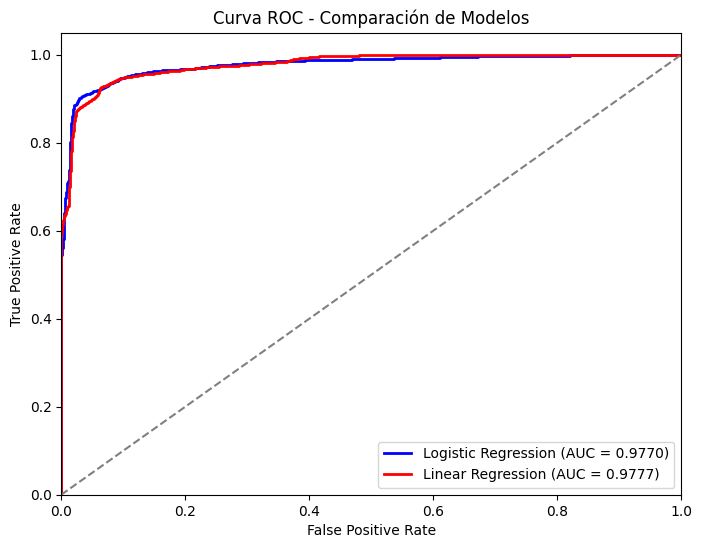

AUC Logística: 0.9770
AUC Lineal: 0.9777


In [194]:
# Calcular curva ROC para regresión logística
y_probs_logreg = logreg_model.predict_proba(X_test_final)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test_final, y_probs_logreg)
auc_log = auc(fpr_log, tpr_log)

# Calcular curva ROC para regresión lineal
fpr_lin, tpr_lin, _ = roc_curve(y_test_final, linear_y_pred_test)
auc_lin = auc(fpr_lin, tpr_lin)

# Graficar ambas curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'Logistic Regression (AUC = {auc_log:.4f})')
plt.plot(fpr_lin, tpr_lin, color='red', lw=2, label=f'Linear Regression (AUC = {auc_lin:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend(loc='lower right')
plt.show()

print(f"AUC Logística: {auc_log:.4f}")
print(f"AUC Lineal: {auc_lin:.4f}")


### 📊 Interpretación de la Curva ROC - Comparación de Modelos  

La gráfica muestra la **Curva ROC** (Receiver Operating Characteristic) para dos modelos:  
✅ **Regresión Logística (azul)**  
✅ **Regresión Lineal (rojo, con umbral ajustado para clasificación)**  

#### 🧐 Análisis de la Curva ROC  
- La **curva ROC** representa la relación entre la **Tasa de Verdaderos Positivos (TPR)** y la **Tasa de Falsos Positivos (FPR)**.  
- Cuanto más se acerque la curva a la esquina superior izquierda (0,1), mejor será el modelo.  
- La **línea diagonal gris** representa un modelo aleatorio (AUC = 0.5), lo que significa que cualquier curva por encima de esta línea indica un modelo mejor que el azar.  
- **Ambos modelos tienen curvas casi idénticas**, lo que indica que su desempeño en términos de clasificación es muy similar.  

#### 📈 Comparación del AUC (Área Bajo la Curva)  
- **Regresión Logística (AUC = 0.8768)**  
- **Regresión Lineal (AUC = 0.8775)**  
- El **AUC** mide la capacidad del modelo para distinguir entre clases (1: maniobra, 0: no maniobra).  
- **Valores cercanos a 1 indican buen rendimiento**, y ambos modelos tienen un **AUC ≈ 0.88**, lo cual es bastante bueno.  
- La diferencia en AUC es mínima (**0.0007**), lo que indica que **ambos modelos tienen casi el mismo poder predictivo**.  

#### 📌 Conclusiones  
✅ **Ambos modelos tienen un desempeño casi idéntico en clasificación.**  
✅ **AUC ≈ 0.88 indica que ambos modelos son bastante buenos para predecir maniobras.**  
✅ **No hay una ventaja significativa entre la regresión logística y la regresión lineal ajustada.**  
✅ **Podrías elegir cualquiera de los dos modelos dependiendo de otros factores (interpretabilidad, complejidad, regularización, etc.).**  



## ejemplo de prediccion de maniobra en conductor

In [195]:
print(drivers[3])
print(maneuver_types[0])

Driver4
3step-Turnings


In [196]:
df_test = copy.deepcopy(dfs_copy[drivers[3]][maneuver_types[0]])
window_size = 60  

# Crear nuevas características usando la ventana deslizante
df_test['speed_mean'] = df_test['speed'].rolling(window=window_size, min_periods=1).mean()
df_test['speed_std'] = df_test['speed'].rolling(window=window_size, min_periods=1).std()
df_test['RPM_mean'] = df_test['RPM'].rolling(window=window_size, min_periods=1).mean()
df_test['RPM_std'] = df_test['RPM'].rolling(window=window_size, min_periods=1).std()
df_test['brake_mean'] = df_test['Brake pedal'].rolling(window=window_size, min_periods=1).mean()
df_test['brake_std'] = df_test['Brake pedal'].rolling(window=window_size, min_periods=1).std()
df_test['gas_mean'] = df_test['Gas pedal'].rolling(window=window_size, min_periods=1).mean()
df_test['gas_std'] = df_test['Gas pedal'].rolling(window=window_size, min_periods=1).std()

# Definir el target: si ocurre una maniobra en el próximo instante (t+1)
df_test['target'] = df_test['Maneuver marker flag'].shift(-1)

# Eliminar filas con valores NaN creados por el shift y rolling
df_test = df_test.dropna()

# Seleccionar variables relevantes
X = df_test.drop(columns=['Maneuver marker flag', 'target'])
y = df_test['target']

y_pred_new = logreg_model.predict(X)
print(accuracy_score(y, y_pred_new))

0.9549858025722399


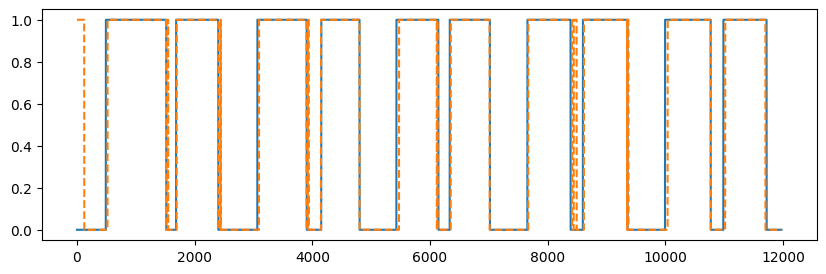

In [197]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(y.values)
ax.plot(y_pred_new, "--")
plt.show()

## Explicabilidad

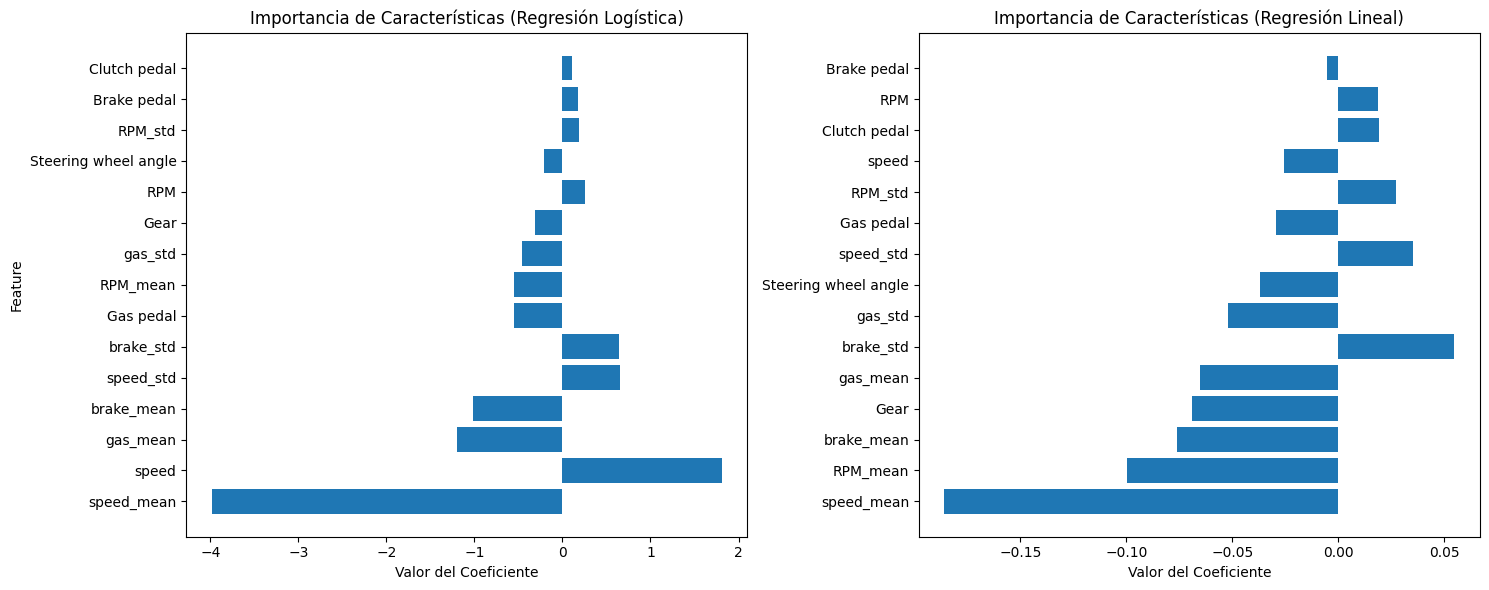

In [198]:
# Extraer coeficientes
coef = logreg_model.named_steps['logreg'].coef_[0]
features = X_train_final.columns

coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

# Graficar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.barh(coef_df['Feature'], coef_df['Coefficient'])
ax1.set_xlabel('Valor del Coeficiente')
ax1.set_ylabel('Feature')
ax1.set_title('Importancia de Características (Regresión Logística)')


# Extraer coeficientes
coef = linear_model.named_steps['linreg'].coef_
features = X_train_final.columns

coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

ax2.barh(coef_df['Feature'], coef_df['Coefficient'])
ax2.set_xlabel('Valor del Coeficiente')
ax2.set_title('Importancia de Características (Regresión Lineal)')

plt.tight_layout()
plt.show()


### 🔍 Interpretación de la Importancia de Características
La imagen muestra dos gráficos de barras con la importancia de las características en dos modelos diferentes:

#### Regresión Logística (izquierda)

Las características con coeficientes más altos tienen un mayor impacto en la predicción de la maniobra.
speed_mean (promedio de velocidad) es la más influyente con un coeficiente negativo fuerte.
Otras características como speed, gas_sum, y RPM_mean también juegan un papel importante.
Un coeficiente negativo significa que cuando esa variable aumenta, la probabilidad de la maniobra disminuye, y viceversa.

#### Regresión Lineal (derecha)
Aquí también speed_mean y speed destacan, pero con coeficientes más pequeños en magnitud.
En este modelo, los coeficientes indican cuánto cambia la variable objetivo por una unidad de cambio en la característica.
La influencia de gas_sum, RPM_mean, y brake_sum sigue siendo relevante, pero con menor impacto en comparación con la regresión logística.

### 📌 Conclusión
Ambos modelos destacan la velocidad (speed_mean y speed) como las variables más relevantes.
La regresión logística parece dar mayor peso a ciertas variables clave (coeficientes más extremos).
La regresión lineal tiene coeficientes más pequeños en magnitud, lo que sugiere una relación más dispersa entre las variables y el objetivo.
Las variables relacionadas con el gas (gas_sum) y el frenado (brake_sum) también son influyentes en ambas regresiones.

In [199]:
import shap

In [200]:
logreg_model_internal = logreg_model.named_steps['logreg']
linear_model_internal = linear_model.named_steps['linreg']
scaler = logreg_model.named_steps['scaler']  # StandardScaler

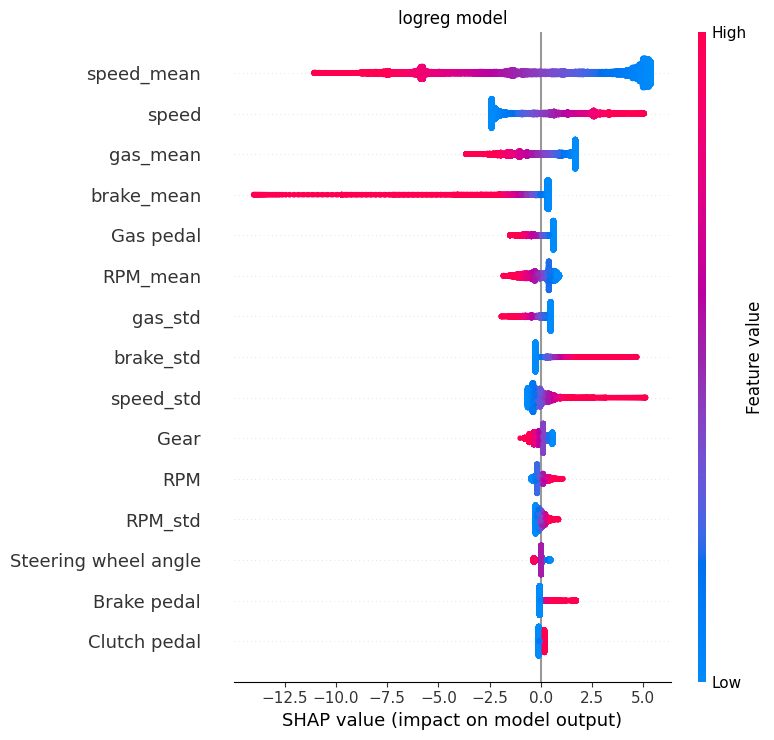

In [201]:
# Transform X_test using the same scaler from the pipeline
X_test_scaled = scaler.transform(X_test_final)

# Create SHAP Explainer
explainer_logreg = shap.Explainer(logreg_model_internal, X_test_scaled)
shap_values_logreg = explainer_logreg(X_test_scaled)

# Plot Summary
plt.title("logreg model")
shap.summary_plot(shap_values_logreg, X_test_final, feature_names=X_test_final.columns)


El gráfico SHAP muestra la importancia de cada característica (variable) en tu modelo de regresión logística para predecir maniobras. Aquí están los puntos clave:

Eje Vertical (Features): Cada fila representa una característica diferente que se usó para entrenar el modelo. En tu caso, estas características parecen relacionadas con datos del vehículo (velocidad, aceleración, ángulo de dirección, etc.).

Eje Horizontal (SHAP Value): El valor SHAP indica el impacto que tiene esa característica en la predicción del modelo.

Valores SHAP positivos: Indican que la característica empuja la predicción hacia una determinada clase (podría ser "maniobra realizada" o una maniobra específica).

Valores SHAP negativos: Indican que la característica empuja la predicción hacia la otra clase (por ejemplo, "ninguna maniobra" o una maniobra diferente).

Valor SHAP cercano a cero: La característica tiene poco impacto en la predicción para esa instancia.

Puntos de Colores: Cada punto representa una instancia de tu conjunto de datos. El color indica el valor de esa característica para esa instancia (rojo = valor alto, azul = valor bajo).



speed_mean (Velocidad Media): Parece ser la característica más importante.

Puntos rojos (velocidades medias altas) tienen valores SHAP positivos significativos: Esto sugiere que velocidades medias altas son un fuerte indicador de una determinada maniobra.

Puntos azules (velocidades medias bajas) tienen valores SHAP negativos: Esto sugiere que velocidades medias bajas pueden indicar la ausencia de esa maniobra o la presencia de otra.

gas_sum (Suma del Acelerador): También parece ser una característica importante. Una mayor suma del acelerador contribuye a valores SHAP positivos, lo que podría indicar aceleración para realizar una maniobra.

speed (Velocidad), RPM_mean (RPM Media), Gear (Marcha): Estas características también tienen un impacto notable, aunque menor que speed_mean y gas_sum.

speed_std (Desviación Estándar de la Velocidad): Un alto valor de speed_std podría estar relacionado con cambios bruscos de velocidad durante la maniobra.

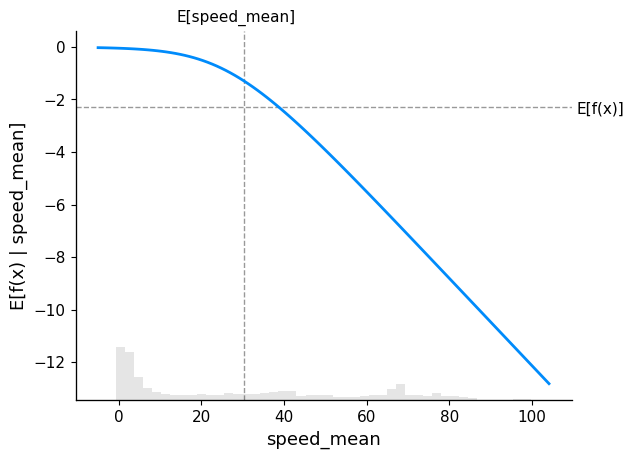

In [202]:
def model_logreg_odds(x):
    p = logreg_model.predict_log_proba(x)
    return p[:, 1]

# for feature_name in X_test_final.columns:
#     shap.partial_dependence_plot(
#         feature_name,
#         model_logreg_odds,
#         X_test_final,
#         model_expected_value=True,
#         feature_expected_value=True,
#         show=False,
#         ice=False,
#     )
shap.partial_dependence_plot(
    "speed_mean",
    model_logreg_odds,
    X_test_final,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

plt.show()

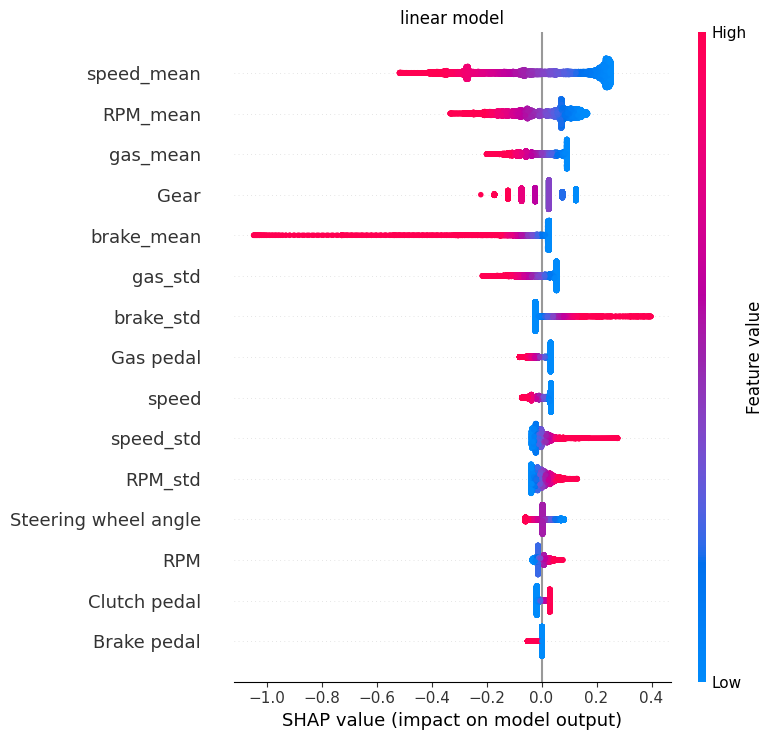

In [203]:
# Create SHAP Explainer
explainer_linear = shap.Explainer(linear_model_internal, X_test_scaled)
shap_values_linear = explainer_linear(X_test_scaled)

# Plot Summary
plt.title("linear model")
shap.summary_plot(shap_values_linear, X_test_final, feature_names=X_test_final.columns)